# DNN and RNN  (ICA data set)

In this notebook we will be using the ICA tax data set to create, train a recurrent neural network. Then we will use this network to predict future ICA tax revenue.

In [ ]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt

import plotly as ply
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf
import tensorflow.keras

# from keras.models import Sequential
# from keras import layers

### Load the data

In [ ]:
data_path = r'data/'

In [2]:
pagos_means_clases=pd.read_csv(data_path+"pagos_ica_cat_means.csv",index_col=None, header=0)
pagos_means_clases.head()

,PERIODO LIQUIDADO,C,F,I,NC,S,V,V/R FACTURA
0,2001-01-01,0.0,0.0,0.0,227055.991736,0.0,0.0,227055.991736
1,2001-02-01,784655.0,0.0,0.0,230310.077848,0.0,0.0,230660.707147
2,2001-03-01,0.0,0.0,0.0,224754.620359,112335.0,0.0,224687.343507
3,2001-04-01,126985.0,0.0,0.0,323778.003776,500037.0,0.0,323765.097423
4,2001-05-01,92704.0,0.0,0.0,260969.423507,0.0,0.0,260864.845867


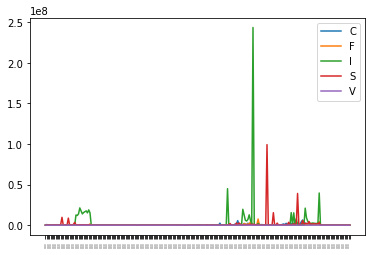

In [3]:
plt.plot(pagos_means_clases['PERIODO LIQUIDADO'], pagos_means_clases['C'], label='C')
plt.plot(pagos_means_clases['PERIODO LIQUIDADO'], pagos_means_clases['F'], label='F')
plt.plot(pagos_means_clases['PERIODO LIQUIDADO'], pagos_means_clases['I'], label='I')
plt.plot(pagos_means_clases['PERIODO LIQUIDADO'], pagos_means_clases['S'], label='S')
plt.plot(pagos_means_clases['PERIODO LIQUIDADO'], pagos_means_clases['V'], label='V')
plt.xticks(rotation=90,fontsize=0.1)
plt.legend(loc='best')
plt.show()

### Pre-process the data

In [7]:
data_size=len(pagos_means_clases)
print(f"data size = {data_size}")

# We will split the data sets as
train_size=12*12
print(f"train size = {train_size}")

test_size=data_size-train_size
print(f"test size = {test_size}")


x=pagos_means_clases.drop(columns='PERIODO LIQUIDADO')

x_train=x[:train_size]
#y_train=y[:train_size]

x_test=x[train_size:]
#y_train=y[train_size:]

# Normalizing the data
data_matrix=x.values
mean_valor = data_matrix[:train_size].mean(axis=0)
data_matrix -= mean_valor
std_valor = data_matrix[:train_size].std(axis=0)
data_matrix /= std_valor

data_matrix=x.values

data size = 240
train size = 144
test size = 96


In [5]:
# In order to train the RNN we pick time windows of "lookback" number of months in the past
# "lookforward" months in the future.
# "batch_size" number of predictions. (i.e, we predict up to 24 months.)

lookback = 60 #  4 years
lookforward = 12 # 1 year
batch_size = 24 # 2 years

# In the case of the number choosen for the first run, we have
# delta=𝑚𝑎𝑥𝑠𝑖𝑧𝑒−(𝑡𝑟𝑎𝑖𝑛𝑠𝑖𝑧𝑒+2+𝑙𝑜𝑜𝑘𝑏𝑎𝑐𝑘+𝑑𝑒𝑙𝑎𝑦)
target_size=data_size-(train_size+2+lookback+lookforward)
print(f'Target size={target_size}')

Target size=22


In order to create the randomize collection of time windows, we will use a generator:

In [91]:
def generator2(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=12):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets
        


# lookback = 60 #  4 years
# lookforward = 12 # 1 year
# batch_size = 24 # 2 years


# For the train generator, we do suffle, that means the loop will run forever, at each iteration it creates 
# a batch of 50 samples (50 sub data_matrices) taken from the data matrix 
# each of it containing (lookback) rows and (features=V_Factura, clases) columns
# For each sample (lookback data points), the generator also gives the value of target value (V_factura)
# in the future (delay) months later.
# The loop is terminated by the RNN by using the fit_generator method.

train_gen_ICA2 = generator2(data_matrix, 
                      lookback=lookback,
                      delay=lookforward,
                      min_index=0,
                      max_index=train_size,
                      shuffle=True,
                      batch_size=batch_size)

# For the test generator, we use shuffle_off, that means, it takes a first sample taken from the data_matrix
# starting from the row (train_size+1) to (train_size +1 +lookback). If the batch_size is enough to fit 
# yet another sample, then it will go to the next batch following the last point of the first batch. It 
# keep doing it until it reaches the end of the data_matrix. 
#(long story short:It divides the 'test_set' in time_sequences sets of size 'batch_size' each)
# If at some point, the test_set is not big enough to accomodate a batch, the batch is cut to the last point
# in the data set.
# For each sample (lookback data points), the generator also gives the value of target value (V_factura)
# in the future (delay) months later.
test_gen_ICA2 = generator2(data_matrix,
                     lookback=lookback,
                     delay=lookforward,
                     min_index=train_size+1,
                     max_index=None,
                     batch_size=batch_size)


#val_steps_ICA2 = (val_size - lookback)
test_steps_ICA2 = (test_size - lookback)        

Now, lets create and train the RNN

Epoch 1/10
100/100 [==============================] - 1s 8ms/step - loss: 1.0768 - val_loss: 3.3556
Epoch 2/10
100/100 [==============================] - 1s 5ms/step - loss: 0.8130 - val_loss: 2.6357
Epoch 3/10
100/100 [==============================] - 1s 5ms/step - loss: 0.6805 - val_loss: 2.2600
Epoch 4/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5778 - val_loss: 2.0603
Epoch 5/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5978 - val_loss: 2.0447
Epoch 6/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5899 - val_loss: 2.0484
Epoch 7/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5399 - val_loss: 2.1413
Epoch 8/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5274 - val_loss: 2.1814
Epoch 9/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5333 - val_loss: 2.2188
Epoch 10/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5131 - val_loss: 2.1995

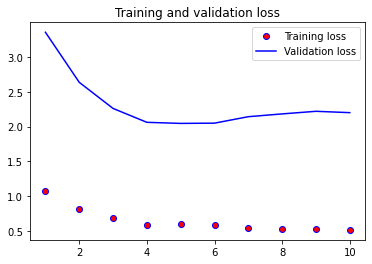

In [97]:
# from numpy import loadtxt
# from tensorflow.keras.models import load_model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_cat = Sequential()
model_cat.add(layers.GRU(16,
                     dropout=0.3,
                     #recurrent_dropout=0.2,
                     input_shape=(None, data_matrix.shape[-1]),
                     kernel_regularizer='l2'))

# model_cat.add(layers.Dense(32, activation='relu',kernel_regularizer='l2'))
# model_cat.add(layers.Dropout(0.3))

model_cat.add(layers.Dense(1))

model_cat.compile(optimizer=RMSprop(), loss='mae')
history_cat = model_cat.fit_generator(train_gen_ICA2,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=test_gen_ICA2,
                              validation_steps=test_steps_ICA2)

loss_cat = history_cat.history['loss']
val_loss_cat = history_cat.history['val_loss']

epochs = range(1, len(loss_cat) + 1)

plt.figure()

plt.plot(epochs, loss_cat, 'bo', label='Training loss', markerfacecolor='red')
plt.plot(epochs, val_loss_cat, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

And lets make some predictions:

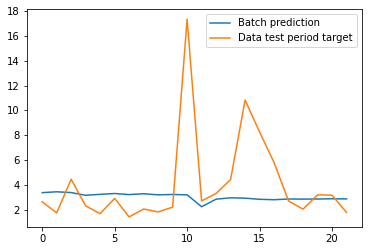

In [98]:
# Take a batch of samples (past),test (future) from the test set using the generator function.
data_pred=next(test_gen_ICA2)

# Lets take a sample from it and feed the model with it:
y_pred_cat =model_cat.predict(data_pred[0])
y_pred_cat=y_pred_cat.flatten()

# Now lets compare the output predicted by the RNN with the real data from the test sample
plt.plot(range(len(y_pred_cat)), y_pred_cat, label='Batch prediction ')
plt.plot(range(len(data_pred[1])),data_pred[1], label='Data test period target')
plt.legend(loc='best')
plt.show()

# Save the model

We can then save the model for future use:

In [4]:
# the easy way. Saving the model (with periodo liquidado) in h5 
model_cat.save(data_path+"model_cat_repo.h5")

NameError: name 'model_cat' is not defined

### Load the model

Now in the future, when we want to use a trained model, we just load it

In [5]:
#load the model from h5 file
#from numpy import loadtxt
from keras.models import load_model
 
# load model
model_cat_load = load_model(data_path+"model_cat_repo.h5")

# summarize model.
model_cat_load.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


# Plotting past data, present data and predicted data

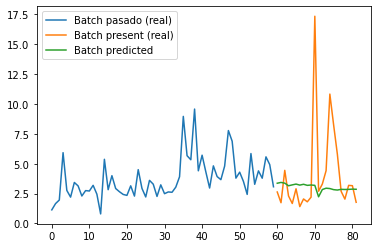

In [102]:
batch_pasado=[y for y in data_pred[0][0][:,-1]]
# batch_peasado=[y*std_valor[-1]+mean_valor[-1] for y in data_pred[0][0][:,-1]]


plt.plot(range(len(batch_pasado)), batch_pasado, label='Batch pasado (real)')
plt.plot(range(len(batch_pasado),len(batch_pasado)+len(data_pred[1])), \
         data_pred[1], label='Batch present (real)')
plt.plot(range(len(batch_pasado),len(batch_pasado)+len(data_pred[1])),\
         y_pred_cat,  label='Batch predicted')

plt.legend(loc='best')
plt.show()

For the sake of clarity, you can identify the time window above with the whole time series 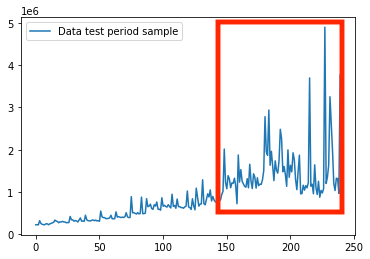

# DNN

To train a DNN, you just need to comment out the GRU layer and uncomment the dense layer in the neural network cell above. We trained and then saved, here then load the trained model.

In [181]:
model_dnn_load = load_model(data_path+"model_cat_dnn.h5")
model_dnn_load.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, None, 32)          256       
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           33        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


Now lets take some data from the original data set (instead of using the generador function) and see what the model predict with it

In [121]:
# I need to give to the predictor, a time series of 96 data points per each prediction. Since I choose to look ahead
# up to one year, i need to give the predictor 48 series (12 months), one for each data point i want to predict in the
# future. Lets take that batch from the original data:
sample_to_predictions=[]
future_window=20
for i in range(future_window):
    sample_to_predictions.append(data_matrix[140+i:140+60+future_window+i])
sample_to_predictions=np.array(sample_to_predictions)

Now we use the load model on the sample set above

In [182]:
y_pred_cat_load =model_cat_load.predict(sample_to_predictions)
y_pred_cat_dnn_load=model_dnn_load.predict(sample_to_predictions)

And lets plot past data, present data, and DNN prediction for present data

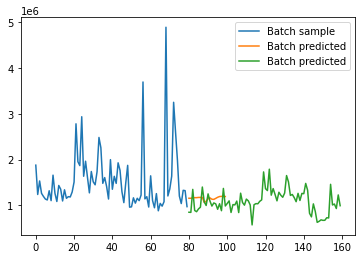

In [191]:
future=train_size +lookback+lookforward+1
#data_target=pagos_means_clases['V/R FACTURA'].iloc[future\
#                        :future+52].values
#data_test_period_target=pagos_df_model2_means_clases['V/R FACTURA'].iloc[-25:].values
#batch_future=[y*std_valor[-1]+mean_valor[-1] for y in  data_pred[1]]



batch_predicted_rnn=[y*std_valor[-1]+mean_valor[-1] for y in  y_pred_cat_load]
batch_predicted_dnn=[y*std_valor[-1]+mean_valor[-1] for y in  y_pred_cat_dnn_load[1]]
sample_unreno=[y*std_valor[-1]+mean_valor[-1] for y in  sample_to_predictions[-1][:,-1]]

#plt.plot(range(len(data_target)), data_target, label='Batch future (from data)')

#plt.plot(range(len(batch_future)), batch_future,linewidth=6, label='Batch future (from generator)')
plt.plot(range(len(sample_unreno)), sample_unreno, label='Batch sample')
plt.plot(range(len(sample_unreno),len(sample_unreno)+len(batch_predicted_rnn)),
         batch_predicted_rnn,  label='Batch predicted by RNN')
plt.plot(range(len(sample_unreno),len(sample_unreno)+len(batch_predicted_dnn)),
         batch_predicted_dnn,  label='Batch predicted by DNN')
plt.legend(loc='best')
plt.show()